# Wildfire Area Prediction Starting Kit

_Authors: Corentin Ambroise, Bastien Galmiche, Luis Montero, Margaux Zaffran_

## Table of contents

1. [Introduction](#introduction)
    1. [Context](#context)
    2. [Objective](#problematic)
    3. [Benefits](#KPI)
    4. [Dependancies](#librairies)
2. [Data](#data)
    1. [Main dataset](#fires)
    2. [Weather datasets](#weather)
    3. [Forest dataset](#forest)
    4. [INSEE dataset](#insee)
    5. [Split](#split)
3. [Loss](#loss)
4. [Exploratory data analysis](#explo)
    1. [Fires](#fires_explo)
    2. [Weather and fires](#weather_explo)
    3. [Forest and fires](#forest_explo)
    4. [INSEE and fires](#insee_explo)
5. [Model](#model)
    1. [Feature extractor](#features)
    2. [Regressor](#regressor)
    3. [Baseline model](#baseline)
    4. [Naive merges](#merges)
6. [RAMP submission](#ramp)

## Introduction <a name="introduction"></a>

### Context <a name="Context"></a>

Every summer, the south of France ravaged by wild fires, due to human activities or natural causes. The firemen struggle fighting these, and it is hard to estimate the required needs in term of equipement and staff.

### Objective <a name="objective"></a>

Our goal is to estimate the surface that will potentially burn when it is declared in order to know the necessary means to deploy in order to counter its spreading.

### Benefits <a name="benefits"></a>

_Give some KPI (vegetation area preserved, life saved...)_ 

### Dependancies <a name="librairies"></a>

In order to be able to run this notebook, you will need the following dependancies installed:

- pandas
- numpy
- matplotlib
- scikit learn
- geopandas

## Data <a name="data"></a>

_Some introduction about  all our datasets, how we've collected them (scrapping or not), collection costs..._

### Main dataset <a name="fires"></a>

The main dataset comes from Promethee, a french data base which contains various information about different fires that occured in the south of France, including the regions Provence-Alpes-Côte-d'Azur, Corse, and the old Languedoc-Roussillon region and a part of the Auvergne-Rhône-Alpes up to St-Etienne. This dataset contains fires that occured between 1973 and 2018.

For each fire, we have different information, each of which corresponds to a column in the dataset:

- __Year__ : the year during which the fire occured
- __Id__ : a number assigned by the computer when the fire is created in the system
- __Department__: department in which the fire was declared
- __INSEE_code__: code insee of the municipality in which the fire was declared
- __Town__: name of the municipality in which the fire was declared
- __Locality__: supplementary precision about the location
- __DFCI_coordinate__: coordinate of the DFCI square in which the fire was declared. This coordinate system is specific to the french DFCI, and corresponds to a small square of 1km side. You can find more information about this coordinate system <a href='http://ccffpeynier.free.fr/Files/dfci.pdf'>here</a> and how they are encoded in these data <a href='https://www.promethee.com/doc/prom_donnees.pdf'>here</a>
- __Signal__: time at which the fire occured
- __Origin__: which service declared the fire
- __Area__: area burned by the fire in square meters

![Map](img/map_fires.png)

### Weather datasets <a name="weather"></a>

_Explain the different weather datasets and for each one, explain each column..._

![Weather_stations](img/map_weather_relief.png)

![Weather_stations_plan](img/map_weather_plan.png)

### Forest dataset <a name="forest"></a>

The forest data set you can use is extracted from an ONF (Office National des Forêts) data set listing the different forests in France, with their shape and location. You can find the original data set <a href=https://www.data.gouv.fr/fr/datasets/forets-publiques-diffusion-publique-1/>here</a>.

Our dataset is slightly different from the original one. First, it only contains forests of the departements for which we have fire data, so departement of the south-east part of France. And secondly, since it takes some time, we precomputed the areas of the forests, which can be used in a regression model. You can find the function which does it in the utils.py file. We will use the geopandas package to read the file which is a geojson. It allows us to have a dataframe containing as columns the properties of the features, and a column geometry containing the geometry of each feature.

We list here what desciptors we have for each forest

- iidtn_frt: id of the forest
- llib_frt: name of the forest
- cdom_frt: wheter it is a state or a communal forest ('NON' for communal forest and 'OUI' for state forests)
- area: the area of the forest inb square meters
- geometry: shapely objects describing the shape of a forest (Polygon or MultiPolygon). You can learn how to manipulate these objects <a href=https://shapely.readthedocs.io/en/stable/manual.html>here</a>



We can visualize bellow what these forests look like.

![Forests](img/map_forests.png)

### INSEE dataset <a name="insee"></a>

_Explain the INSEE dataset, what is each column..._

### Split <a name="split"></a>

Since we have both a temporality and 3 various weather datasets, with different timeperiod, we've splitted our dataset in 3 parts before splitting it between public and private data. These 3 parts are:

- from January 1973 to december 1995 ;
- from January 1996 to december 2009 ;
- from January 2010 to december 2018.

After this first split, we splitted each fold into 70% public and 30% private, respecting the temporality. Before joining them again, we've again splitting with a 70%/30% proportion all the public folds, to get the train folds and the test folds, and did the same with the private folds. We then joined all these folds respectively to obtain finals public train and test sets, private train and test sets. 

At the end of this procedure, the number of raws of each sets is:

- public train set: ADD
- public test set: ADD
- private train set: ADD
- private test set: ADD

This complicated split was chosen in order to assure that you will be tested on the 3 quality level of weather, and that you will be able to train for each quality level.

## Loss <a name="loss"></a>

After our exploratory analysis of the fires data, we can point out 4 caracteristics that our loss would be required to have, in order to learn a model that fits our needs.

- First, we want an asymetric loss which penalizes more under predictions. In our state of mind, in order to prevent a fire to spread, it is best to predict a greater surface burned, in which case we would mobilize more means than necessary, than the opposite.

- Then, we want to penalize more gaps for small values than for big values. For instance, it would be way worst to predict that a fire would burn 0 $m^2$ if it was going to burn 100 $m^2$, than predicting 100 100 $m^2$ or 99 900 $m^2$ burned instead of 100 000 $m^2$. This is why we will apply a log on the prediction and true value before computing their difference.

- In addition we want to penalize more big gaps beetween the prediction and true value, so we will use a powered loss (like MSE)

- And finally, we noticed during the exploratory analysis that most of the fires burned mostly nothing, so the data set is very imbalanced (about 75% of zeros). We need to add something to the loss so it does not always predict zero.

The loss we finally came up with a modified version of the quad quad loss, with an additional term to ensure we do not predict zero everytime.

$$\mathcal{L}_\alpha\left(y,\hat{y}\right) = 2\left( \alpha + (1-2\alpha)\mathbb{1}_{\{y-\hat{y} < 0\}} \right)\left(log(y) - log(\hat{y}) \right)^{2} + c\mathbb{1}_{\{y\neq0 \text{ and } \hat{y}=0\}}$$


In [101]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [106]:
alpha = 0.7
p = 2
y = [0.0001,12,20,55,150,400,1100,2980,8100,22000,60000,160000,440000]
ypred = np.arange(0.0001,500000,10)

In [126]:
def quadquadlog(alpha,p,y,ypred):
    return 2*(alpha+(1-2*alpha)*(1*((np.log(y)-np.log(ypred)) < 0)))*((np.log(y)-np.log(ypred))**p)

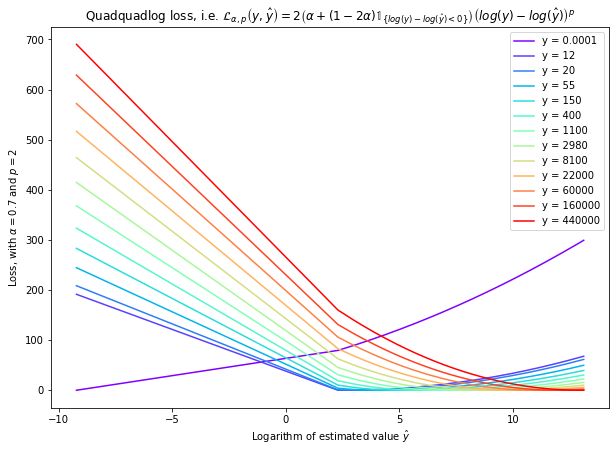

In [134]:
plt.figure(figsize=(10,7))
colors = cm.rainbow(np.linspace(0, 1, len(y)))
for elem, c in zip(y, colors):
    plt.plot(np.log(ypred), quadquadlog(alpha,p,elem,ypred),color=c,label='y = '+str(elem))
plt.legend()
plt.xlabel(r'Logarithm of estimated value $\hat{y}$')
plt.ylabel(r'Loss, with $\alpha = 0.7$ and $p = 2$')
plt.title(r'Quadquadlog loss, i.e. $\mathcal{L}_{\alpha,p}\left(y,\hat{y}\right) = 2\left( \alpha + (1-2\alpha)\mathbb{1}_{\{log(y)-log(\hat{y}) < 0\}} \right)\left(log(y) - log(\hat{y}) \right)^{p}$')
plt.show()
#plt.savefig('Quadquadlog_loss_0.7_2.png')

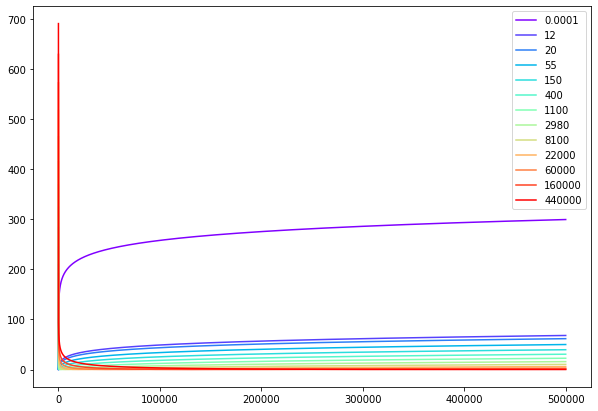

In [128]:
plt.figure(figsize=(10,7))
colors = cm.rainbow(np.linspace(0, 1, len(y)))
for elem, c in zip(y, colors):
    plt.plot(ypred, quadquadlog(alpha,p,elem,ypred),color=c,label=elem)
plt.legend()

## Exploratory data analysis  <a name="explo"></a>

### Fires  <a name="fires_explo"></a>

- __Type de Feu__ : it can either be a forest fire, so a regular one, with a minimum burning surface of a square meter, or an AFERPU, only a fire start which did not burn anything really. Forest fires and AFERPU are respectively encoded 0 and 9


### Weather and fires <a name="weather_explo"></a>

_Analysis of the correlation between weather and fires_

### Forest and fires <a name="forest_explo"></a>

_Analysis of the correlation between forest area and fires_

### INSEE and fires <a name="insee_explo"></a>

_Analysis of the correlation between INSEE data and fires_

## Model  <a name="model"></a>

### Feature extractor  <a name="features"></a>

_Explain what should be done in the feature extractor, and to illustrate give a naive example (converting the non numeric column into numeric ones_

### Regressor  <a name="regressor"></a>

_Explain what should contain the regressor.py file and to illustrate give a naive example_

### Baseline model  <a name="baseline"></a>

_Give a naive model (will surely have been implemented in the 2 previous sections), and train it to obtain its score_

### Naive merges  <a name="merges"></a>

_Show the improvements with our additional datasets, highlight that for this the datasets should be in the submission folder, as are the feature_extractor.py and regressor.py files._

## RAMP submission <a name="ramp"></a>

_Explain how to compute a submission locally_